In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
#import tensorflow as tf
#from tensorflow.contrib.factorization import WALSMatrixFactorization
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp

In [16]:
#read tumor table
TumorSample_table = pd.read_csv("../EB++AdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.xena",sep='\t', index_col=0)
TumorSample_table = TumorSample_table.dropna()

In [17]:
Pathway_Alteration = pd.read_csv("../alterations/genomic_alteration_matrices.Pathway_level.tsv",sep='\t', index_col=0)
Pathway_Alteration = Pathway_Alteration.dropna()
Pathway_Alteration = Pathway_Alteration.astype(int)
Pathway_Alteration = Pathway_Alteration.reindex(columns=['Cell_Cycle', 'HIPPO', 'MYC', 'NOTCH', 'NRF2', 'PI3K', 'RTK RAS', 'TGF-Beta', 'TP53',  'WNT'])

In [18]:
#read curated pathway templates, descriptions of pathways
CELL_CYCLE_Table = pd.read_csv("../curated/curated_pathway_templates.Cell_Cycle.tsv",sep='\t', index_col=0)
HIPPO_Table = pd.read_csv("../curated/curated_pathway_templates.HIPPO.tsv",sep='\t', index_col=0)
MYC_Table = pd.read_csv("../curated/curated_pathway_templates.MYC.tsv",sep='\t', index_col=0)
NOTCH_Table = pd.read_csv("../curated/curated_pathway_templates.NOTCH.tsv",sep='\t', index_col=0)
NRF2_Table = pd.read_csv("../curated/curated_pathway_templates.NRF2.tsv",sep='\t', index_col=0)
PI3K_Table = pd.read_csv("../curated/curated_pathway_templates.PI3K.tsv",sep='\t', index_col=0)
RTK_RAS_Table = pd.read_csv("../curated/curated_pathway_templates.RTK_RAS.tsv",sep='\t', index_col=0)
TGF_BETA_Table = pd.read_csv("../curated/curated_pathway_templates.TGF-Beta.tsv",sep='\t', index_col=0)
TP53_Table = pd.read_csv("../curated/curated_pathway_templates.TP53.tsv",sep='\t', index_col=0)
WNT_Table = pd.read_csv("../curated/curated_pathway_templates.WNT.tsv",sep='\t', index_col=0)


CELL_CYCLE = tuple(set(CELL_CYCLE_Table.index).intersection(set(TumorSample_table.index))) #15 original curated genes, 0 lost due to NA
HIPPO  = tuple(set(HIPPO_Table.index).intersection(set(TumorSample_table.index)))          #38 original curated genes,  3 lost due to NA
MYC = tuple(set(MYC_Table.index).intersection(set(TumorSample_table.index)))               #13 original curated genes, 1 lost due to NA
NOTCH = tuple(set(NOTCH_Table.index).intersection(set(TumorSample_table.index)))           #71 original curated genes, 5 lost due to NA
NRF2 = tuple(set(NRF2_Table.index).intersection(set(TumorSample_table.index)))             #3 original curated genes, 0 lost due to NA
PI3K = tuple(set(PI3K_Table.index).intersection(set(TumorSample_table.index)))             #29 original curated genes, 1 lost due to NA
RTK_RAS = tuple(set(RTK_RAS_Table.index).intersection(set(TumorSample_table.index)))       #84 original curated genes, 5 lost due to NA
TGF_BETA = tuple(set(TGF_BETA_Table.index).intersection(set(TumorSample_table.index)))     #7 original curated genes, 0 lost due to NA
TP53 = tuple(set(TP53_Table.index).intersection(set(TumorSample_table.index)))             #6 original curated genes, 0 lost due to NA
WNT = tuple(set(WNT_Table.index).intersection(set(TumorSample_table.index)))               #68 original curated genes, 10 lost due to NA
ALL_PATHWAY_GENES = sum((CELL_CYCLE, HIPPO, MYC, NOTCH, NRF2, PI3K, RTK_RAS, TGF_BETA, TP53, WNT), ())
PATHWAYS = [CELL_CYCLE, HIPPO, MYC, NOTCH, NRF2, PI3K, RTK_RAS, TGF_BETA, TP53, WNT]

In [21]:
#Paradigm Gene Expression Scores
Paradigm_Pathway_Score = pd.read_csv("../tcga/TCGA_Tumor_Gene_Expression/paradigm_pathway_activity.txt", sep="\t",index_col=0) 

#Somatic Mutations 
Somatic_Mutation_Table = pd.read_csv("../tcga/TCGA_Tumor_Gene_Expression/somatic_mutation/mc3.v0.2.8.PUBLIC.nonsilentGene.xena",sep='\t', index_col=0)
Somatic_Mutation_Mapping = pd.read_csv("../tcga/TCGA_Tumor_Gene_Expression/somatic_mutation/hugo_gencode_good_hg19_V24lift37_probemap",sep='\t', index_col=0)

#Copy Number Variance (CNV) tables ## -1 -> deletion, 0 -> normal, 1 -> overexpressed
CNV_Threshold = pd.read_csv("../tcga/TCGA_Tumor_Gene_Expression/copy_number_variance/CNV_Threshold",sep='\t', index_col=0) ## what do 0,1,2 mean

#Methylation tables
Methylation_Table = pd.read_csv("../tcga/TCGA_Tumor_Gene_Expression/methylation/HumanMethylation27",sep='\t', index_col=0)
ID_Gene_Map_Methylation = pd.read_csv("../tcga/TCGA_Tumor_Gene_Expression/methylation/illuminaMethyl27K_hg18_gpl8490_TCGAlegacy",sep='\t', index_col=0)

In [22]:
##can possibly decrease learning rate for each step, optimize beta/alpha
## scipy to optrimize, gradient descent

def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02):
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])           #error term between actual and predicted, initally 0
                    for k in range(K):
                        #matrix obtained by rate_of_step(alpha) * gradient - regularization(beta term) of constant variables
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])  
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])
        eR = np.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * ( pow(P[i][k],2) + pow(Q[k][j],2) )
        if e < 0.001:
            break
    return P, Q.T

#possibly could improve with weighted alternating least square , regularized $http://ethen8181.github.io/machine-learning/recsys/1_ALSWR.html

In [23]:
#onco gene (OG) or tumor supressor (TSG)
#for each pathway, create a dict with key = (pathway, gene) -> value = OG or TSG
OG_TSG = {}
pathway_index = 0
pathway_to_table = {0 :CELL_CYCLE_Table , 1 : HIPPO_Table , 2 : MYC_Table , 3 : NOTCH_Table , 4 : NRF2_Table , 
                    5 : PI3K_Table, 6 : RTK_RAS_Table , 7 : TGF_BETA_Table , 8 : TP53_Table, 9 : WNT_Table}

for pathway in [CELL_CYCLE, HIPPO, MYC, NOTCH, NRF2, PI3K, RTK_RAS, TGF_BETA, TP53, WNT]:
    for gene in pathway:
        if (pathway_to_table[pathway_index].loc[[gene],['OG/TSG']] == 'OG').bool():
            OG_TSG[gene] = 'OG'
        else:
            OG_TSG[gene] = 'TSG'
    pathway_index += 1
#mean centering for gene normalization
TumorSample_table = TumorSample_table.apply(lambda x: x-x.mean())
if OG_TSG[gene] == 'TSG':            
    TumorSample_table.loc[gene, :] = TumorSample_table.loc[gene, :] * -1 #TSG,

In [33]:
#input matrix so if tumor or onco is edited, normalize, consider different threshold for resultant matrix
#consider wals-r
patients = set(Pathway_Alteration.index).intersection(set(TumorSample_table.columns))
small_patients = random.sample(patients,1000)
predictions = pd.DataFrame()

for pathway in PATHWAYS:
    R = np.array(TumorSample_table.loc[pathway,small_patients]) #gene (N) by patient (M)
    N = len(pathway) # number gene
    M = len(small_patients) # patients
    K = 1
    P = np.random.rand(N,K)
    Q = np.random.rand(M,K)
    nP, nQ = matrix_factorization(R, P, Q, K)
    nR = np.dot(nP, nQ.T)
    predictions = pd.concat([pd.DataFrame(nQ),predictions],axis=1)
predictions.columns = ['Cell_Cycle', 'HIPPO', 'MYC', 'NOTCH', 'NRF2', 'PI3K', 'RTK RAS', 'TGF-Beta','TP53',  'WNT']
predictions.index = small_patients

KeyboardInterrupt: 

In [40]:
for pathway in predictions.columns:
    for patient in predictions.index:
        pathway_mean = predictions.loc[:, pathway].mean(axis=0)
        pathway_sd = predictions.loc[:, pathway].std(axis=0)
        if predictions.loc[patient, pathway] >  pathway_mean + pathway_sd:
            predictions.loc[patient, pathway] = 1
        else: 
            predictions.loc[patient, pathway] = 0
predictions = predictions.astype(int)

In [41]:
((predictions == Pathway_Alteration.loc[small_patients, predictions.columns]).sum().sum())/(len(small_patients)*10)

0.2676

In [ ]:
'''
paradigm for validation          %%%%%%%%%%%%%%%%#paradigm patients are not the same as tumor sample table?!?!? 
other algorithms
libarries for matrix optimization
libraries algorithms etc, tensorflow
correlation matrix, for pathways to see if 'pathways fire together' 
bader lab gene sets - could try collaborative filtering based on pathway sets $http://download.baderlab.org/EM_Genesets/current_release/Human/symbol/Pathways/
mutation ** not methylation -> xena browser
'''

In [83]:
pd.DataFrame(sklearn.preprocessing.normalize(Paradigm_Pathway_Score), index=Paradigm_Pathway_Score.index, columns=Paradigm_Pathway_Score.columns)
genes = set(ALL_PATHWAY_GENES).intersection(set(Paradigm_Pathway_Score.index))
tasty_patients = set(Paradigm_Pathway_Score.columns).intersection(set(Pathway_Alteration.index))

CELL_CYCLE = set(CELL_CYCLE).intersection(genes) #15 original curated genes, 0 lost due to NA
HIPPO  = set(HIPPO).intersection(genes)         #38 original curated genes,  3 lost due to NA
MYC = set(MYC).intersection(genes) #ginal curated genes, 1 lost due to NA
NOTCH = set(NOTCH).intersection(genes)         #71 original curated genes, 5 lost due to NA
NRF2 = set(NRF2).intersection(genes)          #3 original curated genes, 0 lost due to NA
PI3K = set(PI3K).intersection(genes)        #29 original curated genes, 1 lost due to NA
RTK_RAS = set(RTK_RAS).intersection(genes)      #84 original curated genes, 5 lost due to NA
TGF_BETA = set(TGF_BETA).intersection(genes)     #7 original curated genes, 0 lost due to NA
TP53 = set(TP53).intersection(genes)            #6 original curated genes, 0 lost due to NA
WNT = set(WNT).intersection(genes)             #68 original curated genes, 10 lost due to NA


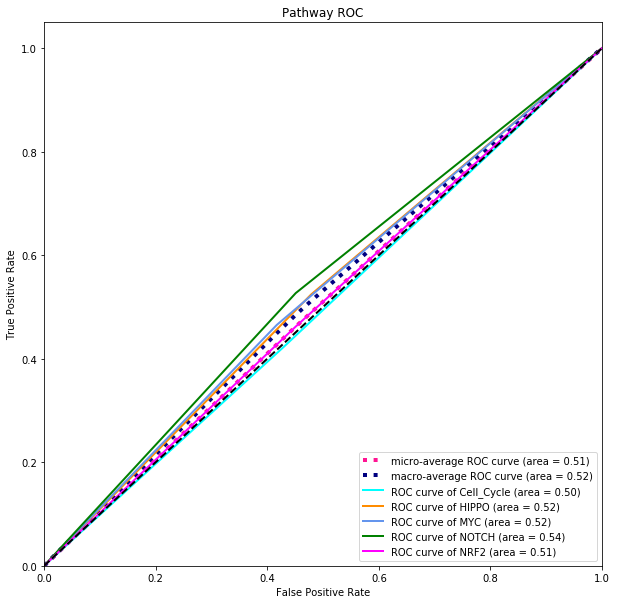

In [42]:
#Plot ROC for each pathway
n_classes = predictions.columns
patients = set(Pathway_Alteration.index).intersection(set(predictions.index))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in n_classes:
    fpr[i], tpr[i], _ = roc_curve(np.array(Pathway_Alteration.loc[small_patients,i]) , np.array(predictions.loc[:,i]))
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.array(Pathway_Alteration.loc[small_patients,i]),  np.array(predictions.loc[:,i]).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in n_classes]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in n_classes:
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(n_classes)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2

plt.figure(figsize=(10, 10))

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'magenta', 'black', 'yellow', 'firebrick', 'red', 'pink'])
for i, color in zip(n_classes, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Pathway ROC')
plt.legend(loc="lower right")
plt.show()